In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
from stanify.calibrator.draws_data_mapper import draws2data2draws
from stanify.calibrator.calib_utilities import check_consistency
import random
random.seed(10)


Compared to prey_predator.ipynb, we added hierarchy (increase R from 1 to 3). Users specify among which `est_param_names` becomes `hier_est_param_names`. Hierarchy in at least one parameter automatically adds subscripts to evey integrated outputs (integrated structure including, but not limited to `target_simulated_vector`).

22:38:34 - cmdstanpy - INFO - compiling stan file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R3/draws2data.stan to exe file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R3/draws2data
22:38:49 - cmdstanpy - INFO - compiled model executable: /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R3/draws2data
22:38:49 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
22:38:49 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R3 --o=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R3/draws2data.hpp /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R3/draws2data.stan
Warning in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R3/draws2data.stan', line 33, column 4: Declaration
    of arrays by pl

chain 1 |          | 00:00 Status

22:38:49 - cmdstanpy - INFO - CmdStan done processing.


22:38:54 - cmdstanpy - INFO - compiling stan file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R3/data2draws.stan to exe file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R3/data2draws
22:39:09 - cmdstanpy - INFO - compiled model executable: /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R3/data2draws
22:39:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

05:08:40 - cmdstanpy - INFO - CmdStan done processing.
05:08:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: ode_rk45: ode parameters and data is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R3/data2draws.stan', line 48, column 8 to column 192)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R3/data2draws.stan', line 62, column 8 to column 59)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R3/data2draws.stan', line 62, column 8 to column 59)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R3/data2draws.stan', line 62, column 8 to column 59)
	Exception: ode_rk45: ode parameters and data is inf, but must

05:08:41 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 17 divergent transitions (68.0%)
	Chain 2 had 8 iterations at max treedepth (32.0%)
	Chain 3 had 25 iterations at max treedepth (100.0%)
	Use function "diagnose()" to see further information.


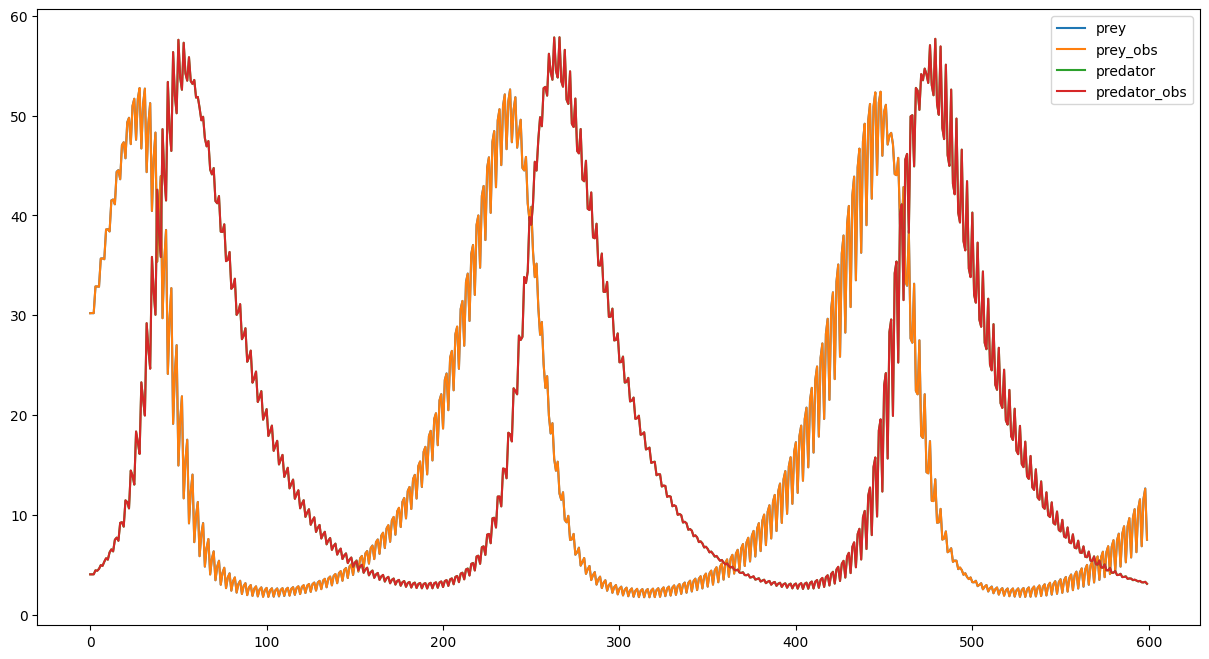

In [2]:
precision ={
    "S": 1, # # of draws from prior
    "M": 100, # # of draws from posterior (# of chains * # of draws from each chain)
    "N": 200, # # of observation
    "R": 3, # # of subgroups for hierarchical Bayes
}

setting = {
    "est_param_names": ("prey_birth_frac", "pred_birth_frac"),
    "hier_est_param_names" : ("pred_birth_frac"),
    "target_simulated_vector_names": ("prey", "predator"),
    "driving_vector_names": ("process_noise_uniform_driving"),
    "model_name": "prey_predator",
}

numeric = {
    "process_noise_uniform_driving": np.random.uniform(low=-.5, high=.5, size = precision['N']),
    'process_noise_scale': 0.1
}

prior = {
    ("prey_birth_frac", "normal", 0.8, 0.08, 0),
    ("pred_birth_frac", "normal", 0.05, 0.005, 0),
    ("m_noise_scale", "normal", .1, .001, 0)
}

output_format = dict(
    prior_predictive=["prey_obs", "predator_obs"],
    posterior_predictive=["prey_obs_post", "predator_obs_post"],
    log_likelihood={
        "loglik": "loglik"
    },
    coords={
        "time": [n for n in range(precision['N'])],
        "stock": setting['target_simulated_vector_names'],
        "region": [r for r in range(precision['R'])]
    },
    dims={
        'initial_outcome': ["stock"],
        'integrated_result': ["time", "stock"],
        'prey': ["time"],
        'predator': ["time"],
        'process_noise': ["time"],
        "prey_obs": ["time"],
        "predator_obs": ["time"],
    }
)

if check_consistency(setting, precision, numeric, prior, output_format):
    model = draws2data2draws('../vensim_models/prey_predator/prey_predator.mdl', setting, precision, numeric, prior, output_format)

In [3]:
modelname = "prey_predator_S1N200Q2R3"
draws2data = az.from_netcdf(f"data/{modelname}/draws2data.nc")
data2draws = az.from_netcdf(f"data/{modelname}/data2draws.nc")

## diagnose numerically with InferenceData
Change before and after adding hierarchy can be seen from `Dimensions`, as hierarchical estimated parameter `pred_birth_frac` and  `prey`, `predator`, `porcess_noise` now have three dimension (=R from precision above).

In [4]:
draws2data

Inference data with groups:
	> prior
	> prior_predictive
	> sample_stats_prior

Same with data2draws. Differences are also shown in index of `Data variables`. e.g. result of estimation for `prey_birth_frac` is (chain, draw) whereas `pred_birth_frac` has (chain, draw, pred_birth_frac_dim_0). Although `process_noise` is included, noise_scale is set to 0 during `data2draws()`, so we can ignore.


In [5]:
data2draws

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [6]:
az.summary(data2draws)

/Users/hyunjimoon/Dropbox/stanify/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_birth_frac[0],0.352,0.415,0.069,1.060,0.169,0.126,7.0,95.0,3.32
pred_birth_frac[1],0.640,0.890,0.067,2.167,0.363,0.270,7.0,96.0,2.61
pred_birth_frac[2],0.351,0.317,0.077,0.848,0.130,0.097,8.0,73.0,3.27
prey_birth_frac,1.127,1.408,0.118,3.510,0.575,0.428,7.0,96.0,3.36
m_noise_scale,1.406,0.863,0.832,2.884,0.353,0.263,7.0,25.0,3.47
...,...,...,...,...,...,...,...,...,...
"process_noise[24.76, 1]",0.014,0.000,0.014,0.014,0.000,0.000,12.0,7.0,1.57
"process_noise[24.76, 2]",0.014,0.000,0.014,0.014,0.000,0.000,14.0,83.0,1.87
"process_noise[24.885, 0]",0.013,0.000,0.013,0.014,0.000,0.000,17.0,74.0,1.91
"process_noise[24.885, 1]",0.013,0.000,0.013,0.014,0.000,0.000,12.0,7.0,1.54


## Diagnose visually with time series, trace, pair, rank plots
### time series of target simulated and its measurement noise added observed vector (TODO: plot this by region)

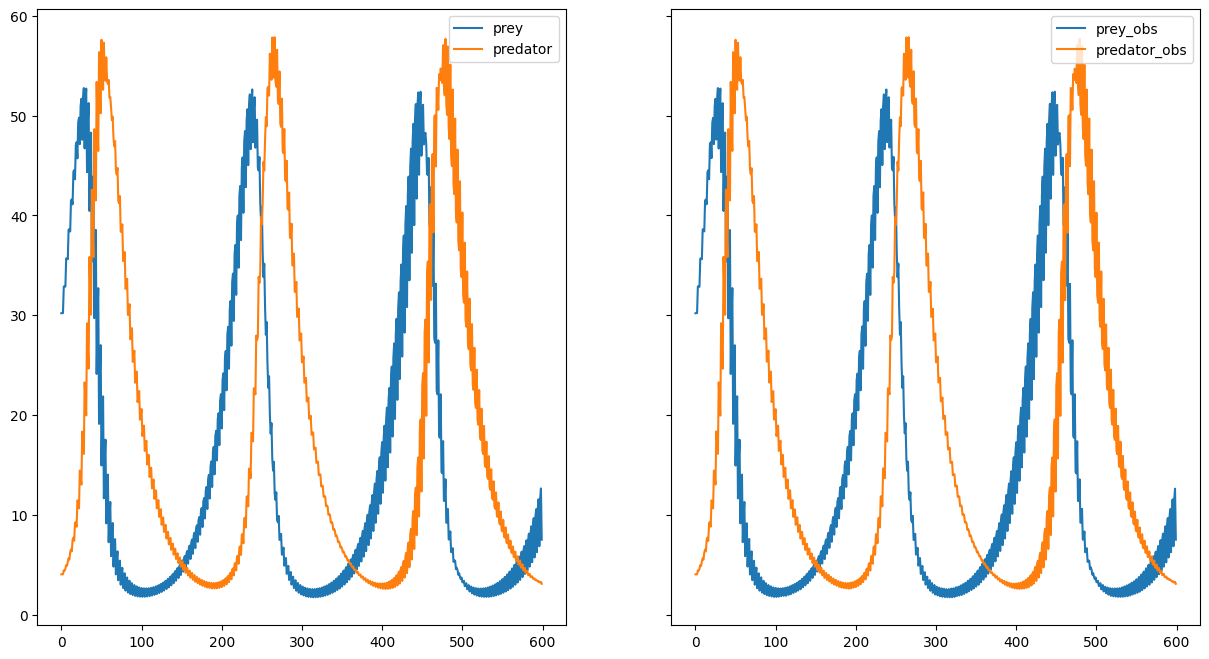

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), sharey=True)

for target in ['prey', 'predator']:
    ax1.plot(draws2data.prior[target].mean('prior_draw').to_dataframe().values, label=f"{target}")
ax1.legend(loc= 'upper right')

for target in ['prey', 'predator']:
    ax2.plot(draws2data.prior_predictive[f'{target}_obs'].mean('prior_draw').to_dataframe().values, label=f"{target}_obs")
ax2.legend(loc= 'upper right')


### trace plot
shows estiamted prameters are not well-mixed between chains

/Users/hyunjimoon/Dropbox/stanify/venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<AxesSubplot: title={'center': 'pred_birth_frac'}>,
        <AxesSubplot: title={'center': 'pred_birth_frac'}>]], dtype=object)

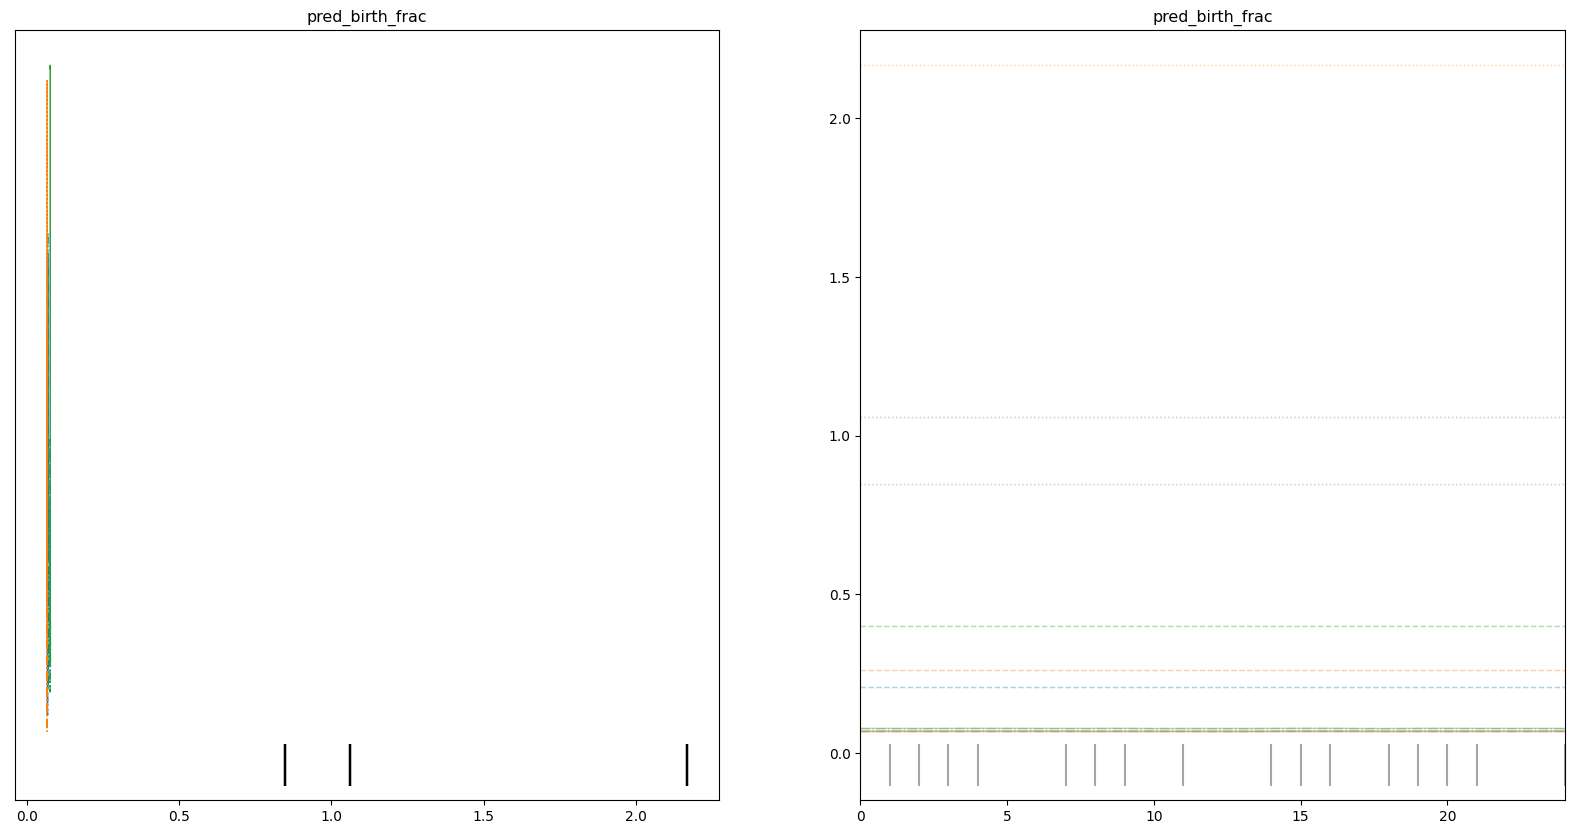

In [10]:
az.plot_trace(data2draws, figsize= (20, 10), var_names= ['pred_birth_frac'])

In [11]:
data2draws.posterior['pred_birth_frac']

<xarray.DataArray 'pred_birth_frac' (chain: 4, draw: 25,
                                     pred_birth_frac_dim_0: 3)>
array([[[0.068901, 0.066885, 0.077253],
        [0.069149, 0.067409, 0.077283],
        ...,
        [0.068999, 0.067009, 0.077245],
        [0.069434, 0.067762, 0.077197]],

       [[1.05951 , 2.16736 , 0.847764],
        [1.05951 , 2.16736 , 0.847764],
        ...,
        [1.05951 , 2.16736 , 0.847764],
        [1.05951 , 2.16736 , 0.847764]],

       [[0.208717, 0.260142, 0.400679],
        [0.208717, 0.260142, 0.400679],
        ...,
        [0.208717, 0.260142, 0.400679],
        [0.208717, 0.260142, 0.400679]],

       [[0.068666, 0.0669  , 0.076986],
        [0.068952, 0.066932, 0.077111],
        ...,
        [0.069137, 0.067144, 0.0772  ],
        [0.068698, 0.067153, 0.076951]]])
Coordinates:
  * chain                  (chain) int64 0 1 2 3
  * draw                   (draw) int64 0 1 2 3 4 5 6 7 ... 18 19 20 21 22 23 24
  * pred_birth_frac_dim_0  (pred_birth_frac_dim_0) int64 0 1 2

/Users/hyunjimoon/Dropbox/stanify/venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<AxesSubplot: title={'center': 'pred_birth_frac\n0'}>,
        <AxesSubplot: title={'center': 'pred_birth_frac\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot: title={'center': 'pred_birth_frac\n1'}>,
        <AxesSubplot: title={'center': 'pred_birth_frac\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot: title={'center': 'pred_birth_frac\n2'}>,
        <AxesSubplot: title={'center': 'pred_birth_frac\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot: title={'center': 'prey_birth_frac'}>,
        <AxesSubplot: title={'center': 'prey_birth_frac'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

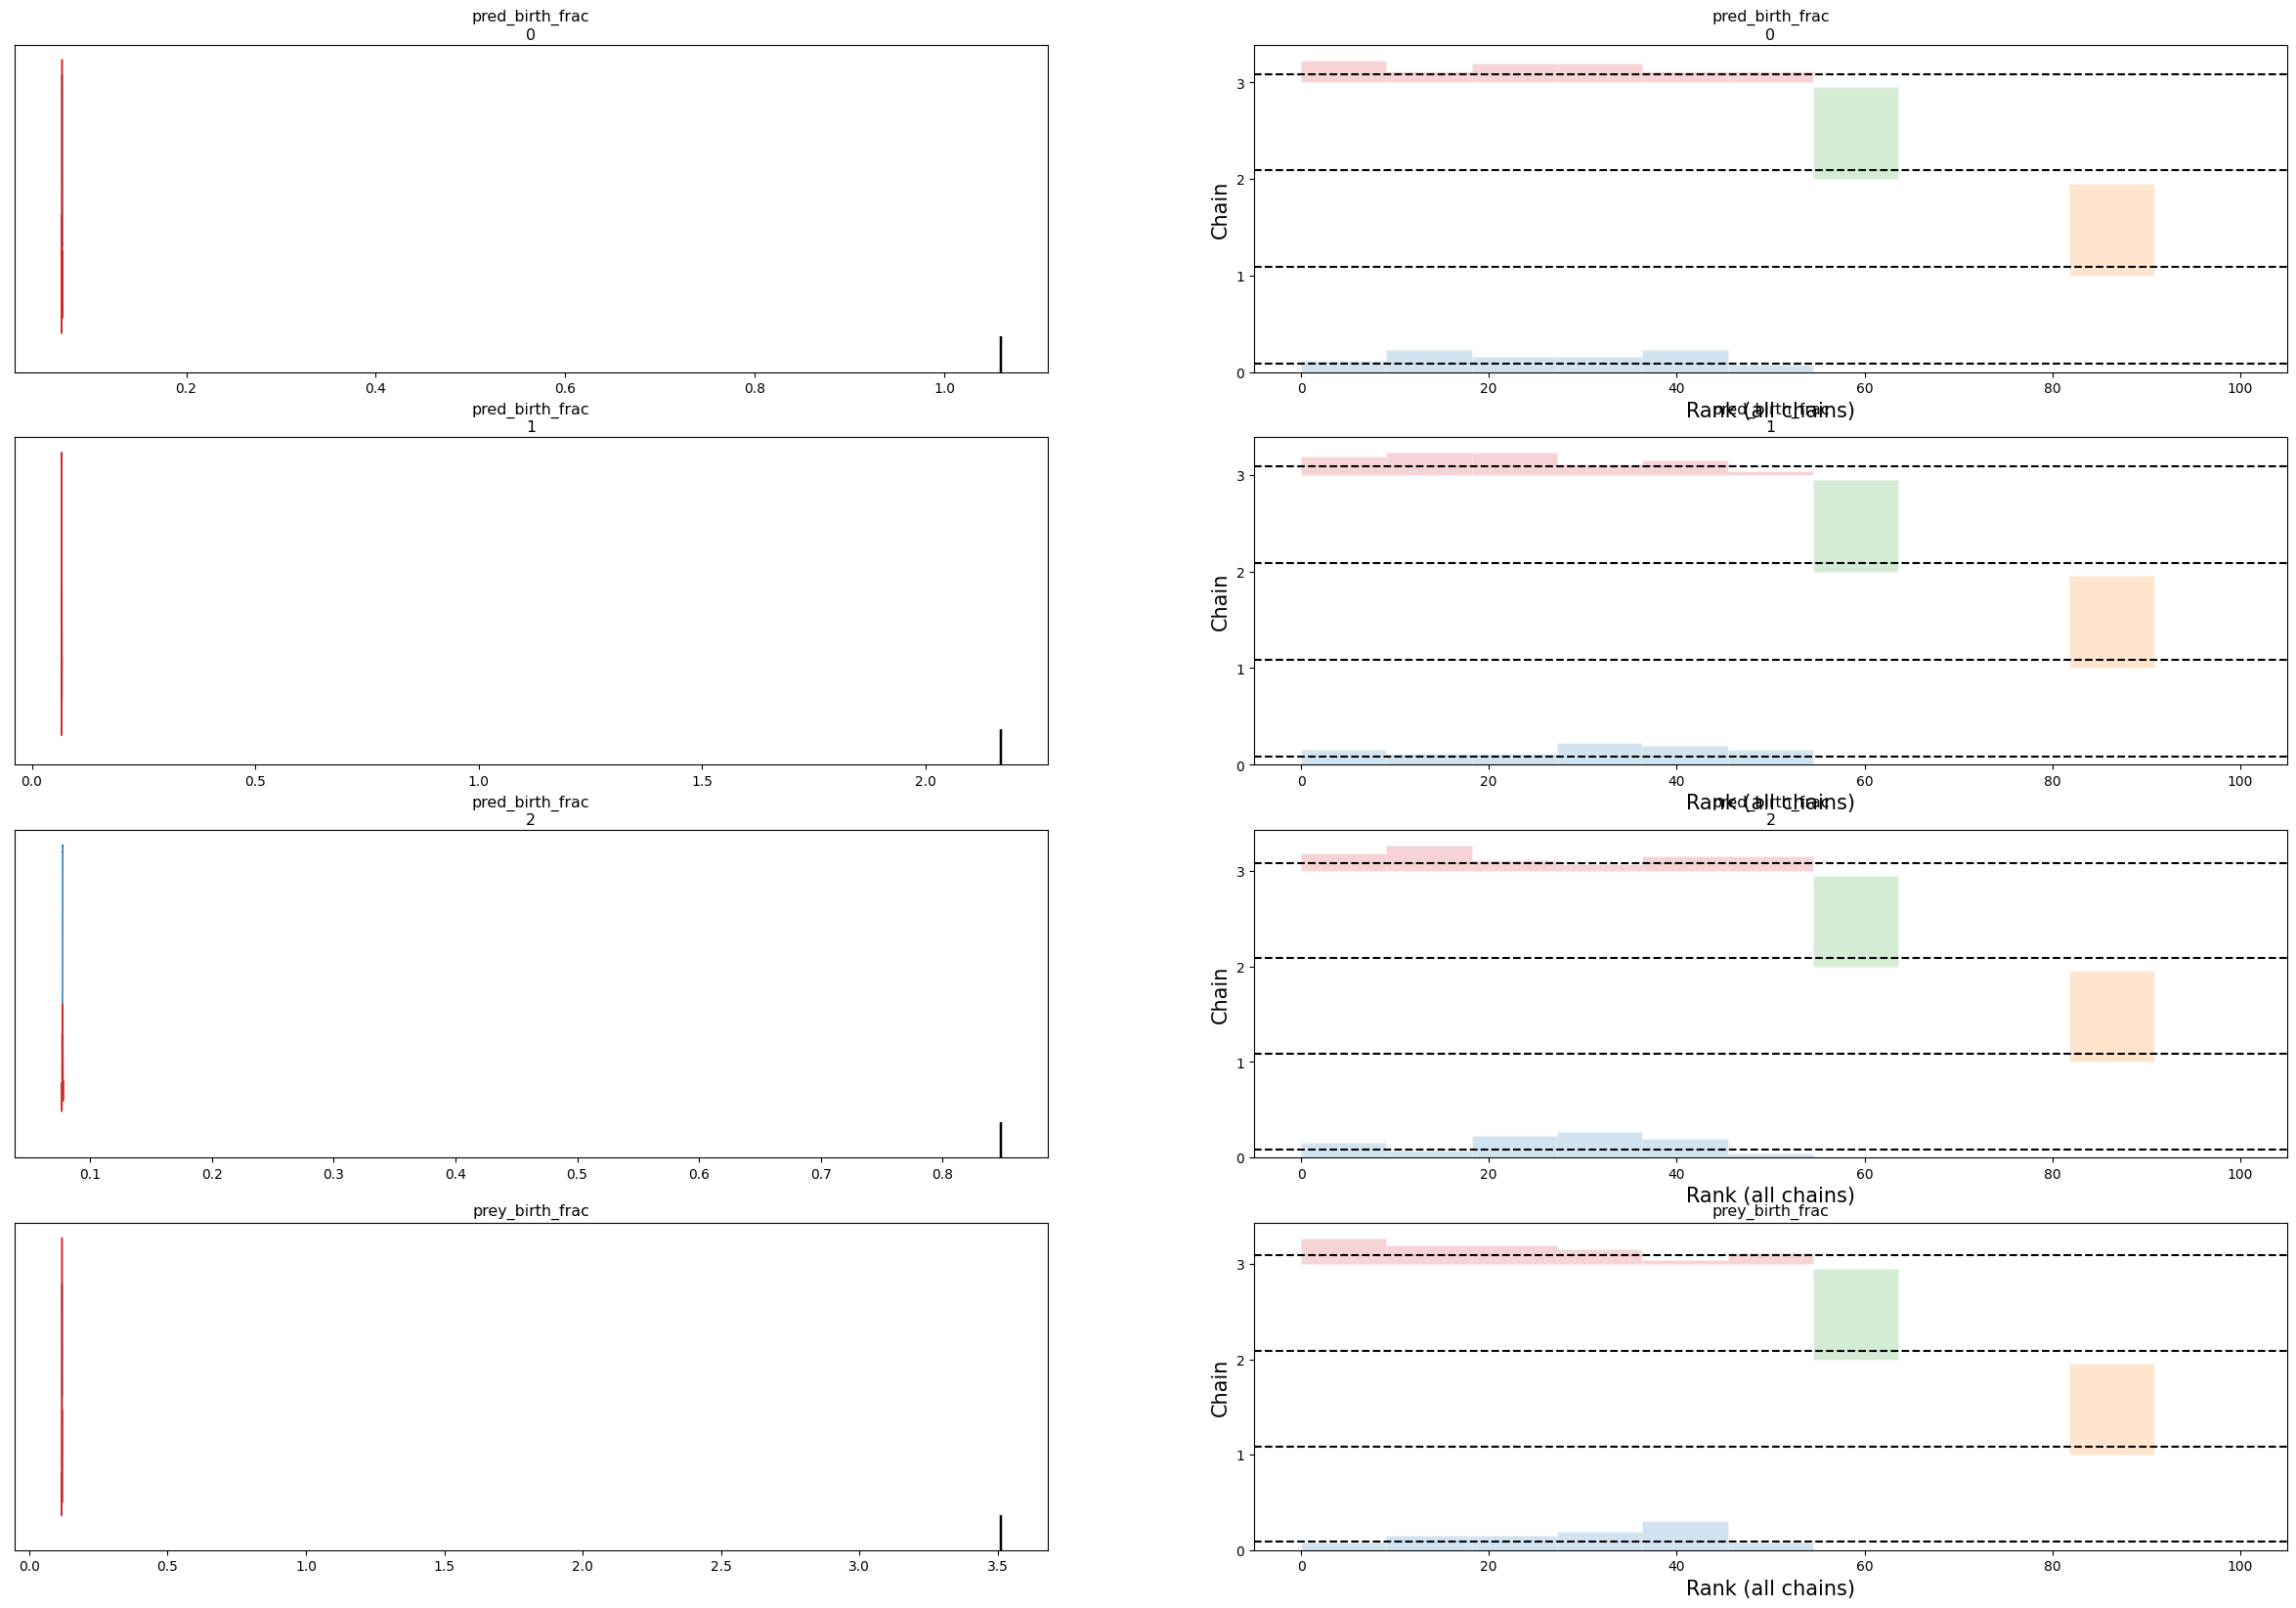

In [22]:
az.plot_trace(data2draws, figsize= (30, 20), var_names= ['pred_birth_frac', 'prey_birth_frac'], kind = "rank_bars", rank_kwargs={"bar_kwargs": {"alpha": 0.2}}, compact = False) # , coords = dict(chain = [0]) selects chain

### pair plot focused and all

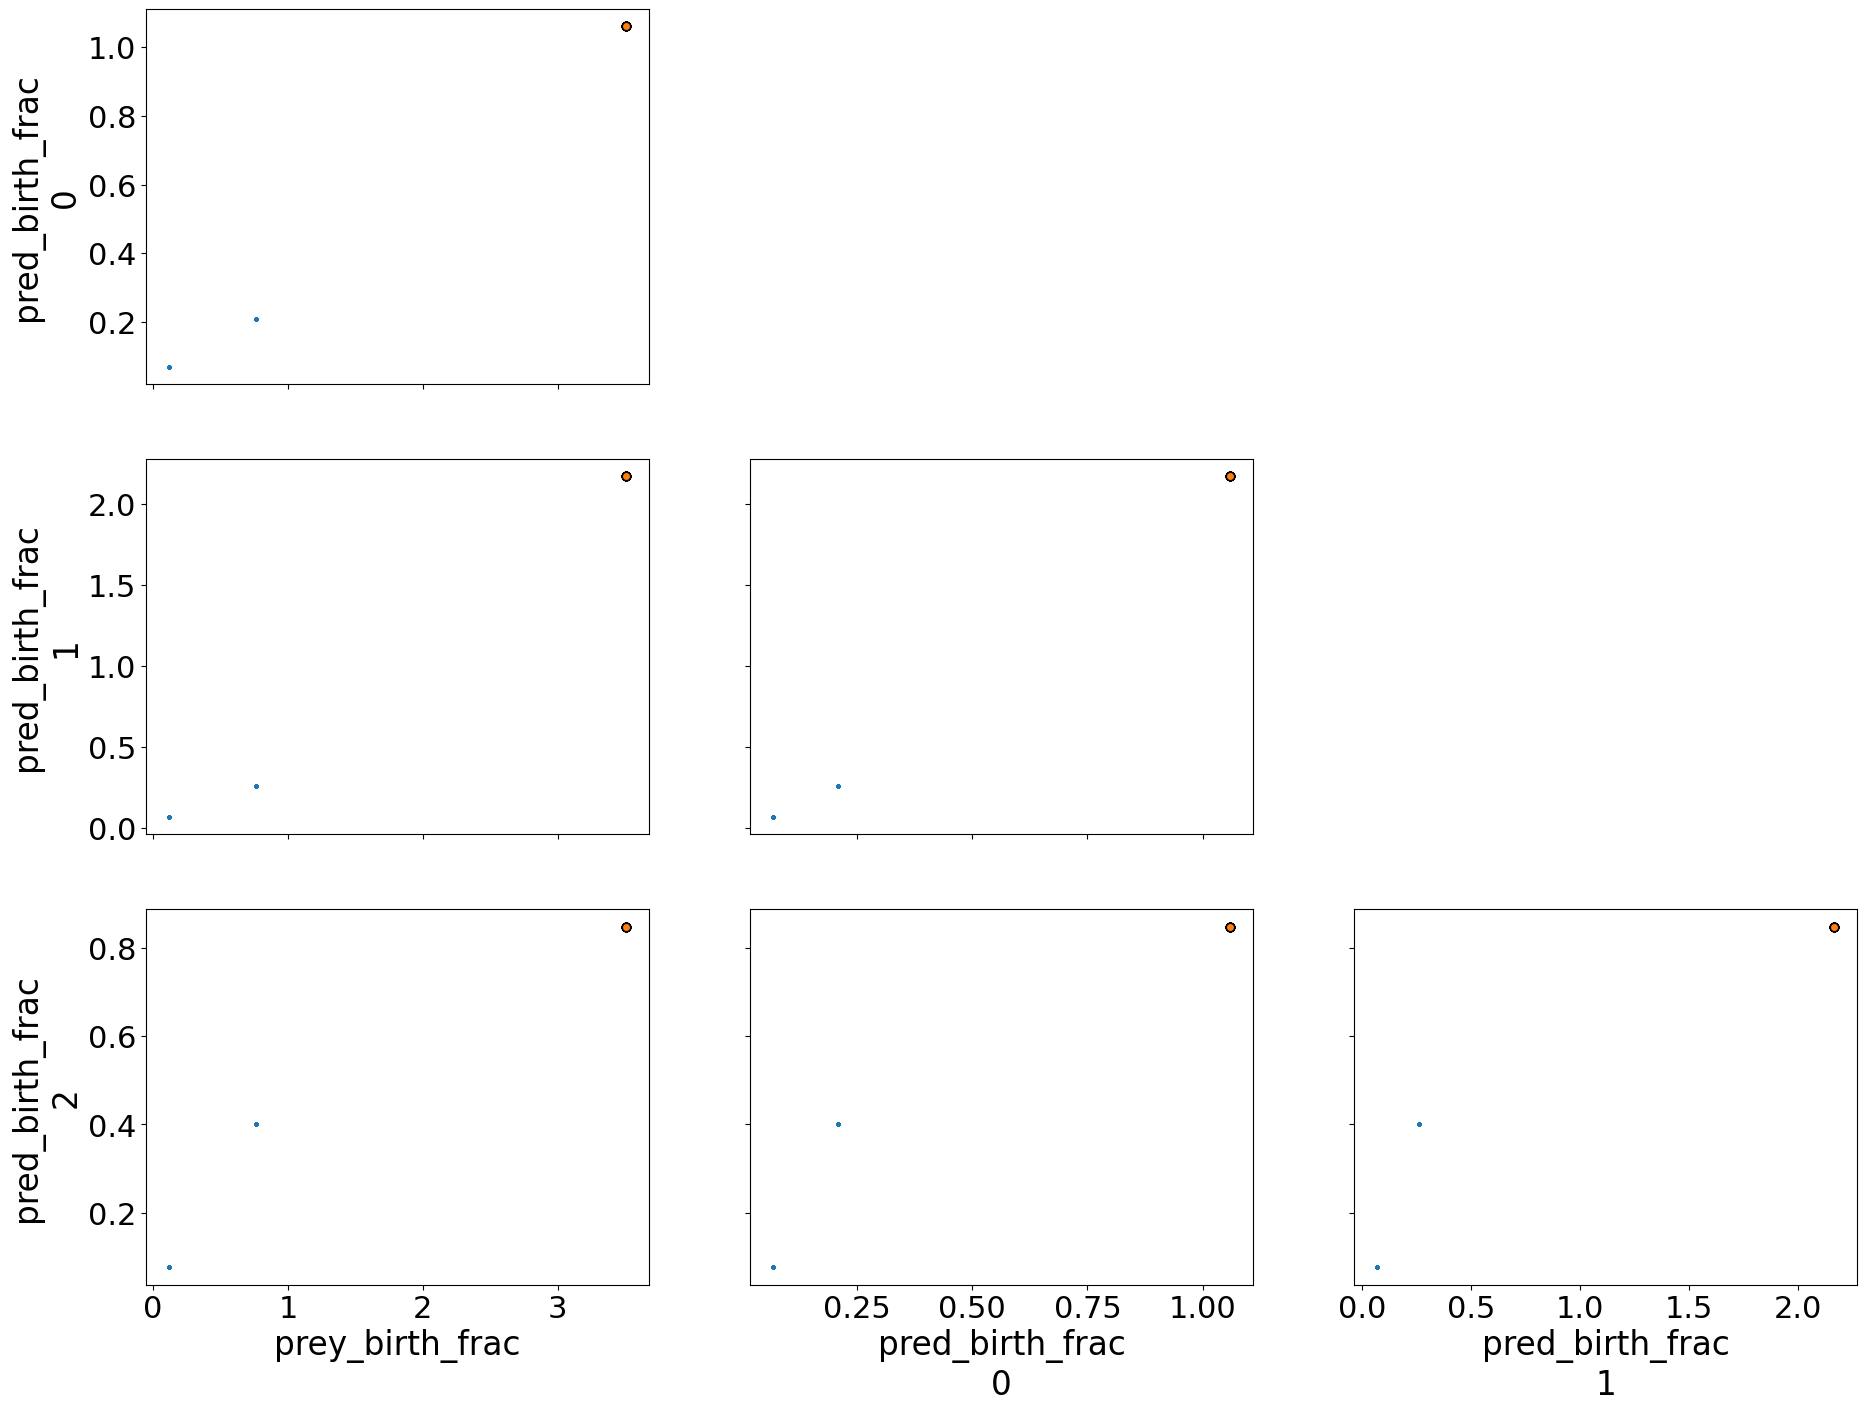

In [23]:
ax = az.plot_pair(data2draws,  var_names=['prey_birth_frac', 'pred_birth_frac'], divergences=True, textsize=22,)

### rank plot
indicates more than one peak

array([<AxesSubplot: title={'center': 'prey_birth_frac'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot: title={'center': 'pred_birth_frac\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

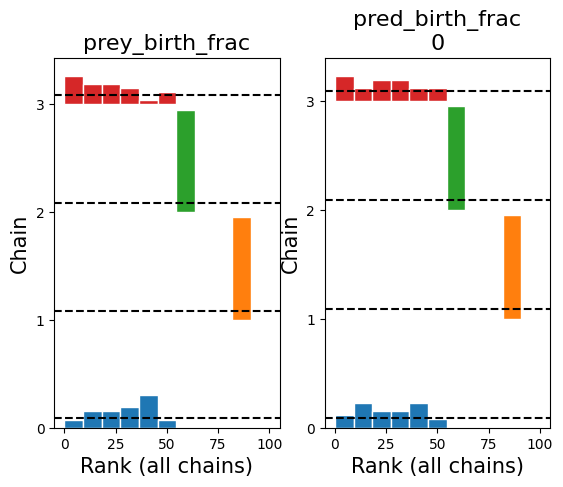

In [25]:
fig, axes = plt.subplots(1, 2)
az.plot_rank(data2draws, var_names=("prey_birth_frac", "pred_birth_frac"), ax=axes)


# Appendix

## model

In [ ]:
print(CmdStanModel(stan_file=f"stan_files/{modelname}/draws2data.stan").code())
print(CmdStanModel(stan_file=f"stan_files/{modelname}/data2draws.stan").code())

In [19]:

data2draws.posterior_predictive

<xarray.Dataset>
Dimensions:                  (chain: 4, draw: 25, predator_obs_post_dim_0: 200,
                              predator_obs_post_dim_1: 3,
                              prey_obs_post_dim_0: 200, prey_obs_post_dim_1: 3)
Coordinates:
  * chain                    (chain) int64 0 1 2 3
  * draw                     (draw) int64 0 1 2 3 4 5 6 ... 18 19 20 21 22 23 24
  * predator_obs_post_dim_0  (predator_obs_post_dim_0) int64 0 1 2 ... 198 199
  * predator_obs_post_dim_1  (predator_obs_post_dim_1) int64 0 1 2
  * prey_obs_post_dim_0      (prey_obs_post_dim_0) int64 0 1 2 3 ... 197 198 199
  * prey_obs_post_dim_1      (prey_obs_post_dim_1) int64 0 1 2
Data variables:
    predator_obs_post        (chain, draw, predator_obs_post_dim_0, predator_obs_post_dim_1) float64 ...
    prey_obs_post            (chain, draw, prey_obs_post_dim_0, prey_obs_post_dim_1) float64 ...
Attributes: (4)

In [20]:
data2draws.observed_data

<xarray.Dataset>
Dimensions:       (time: 200, region: 3)
Coordinates:
  * time          (time) float64 0.01 0.135 0.26 0.385 ... 24.64 24.76 24.89
  * region        (region) int64 0 1 2
Data variables:
    prey_obs      (time, region) float64 ...
    predator_obs  (time, region) float64 ...
Attributes: (4)